# parameter tuned
by random serach 100 times

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import time
import gc
from tqdm import tqdm

In [2]:
!ls

aguiar's_kernel.ipynb
cood
data_visualize.ipynb
ensemble-Corr.ipynb
ensemble.csv
ensemble2.csv
feature_matrix.csv
feature_selection-feature_by_kageyama-25CV-parameter-by-Ivan_noIDs.ipynb
feature_selection-feature_by_olivier-25CV-parameter-by-Ivan_noIDs.ipynb
feature_selection_feature_matrix_by_kageyama.ipynb
feature_selection_feature_matrix_by_olivier.ipynb
feature_selection_feature_matrix_noIDs_by_kageyama.ipynb
featuretools-for-Kageyama.ipynb
featuretools-for-aguiar.ipynb
featuretools-for-olivier.ipynb
featuretools.ipynb
kageyama-25CV_noIDs_delunimportant_90.ipynb
kageyama-25CV_noIDs_delunimportant_92.ipynb
kageyama-25CV_noIDs_delunimportant_94.ipynb
kageyama-25CV_noIDs_delunimportant_96.ipynb
kageyama-25CV_noIDs_delunimportant_96_cood.ipynb
kageyama-25CV_noIDs_delunimportant_96_tuned_by_random.ipynb
kageyama-25CV_noIDs_delunimportant_98.ipynb
kageyama_feature_matrix_25cv_tuned_by_Ivan_sub_noIDs.csv
kageyama_feature_matrix_25cv_tuned_by_Ivan_sub_noIDs_delmissing_delunimportant_794.cs

In [3]:
st = time.time()
df = pd.read_csv('./kageyama_feature_matrix_96.0.csv')
time.time() - st

65.09277606010437

In [4]:
df = df.drop('SK_ID_CURR', axis=1)

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_feats = [f for f in df.columns if df[f].dtype == 'object']
for col in tqdm(categorical_feats):
    if col == 'set' :
        continue
    df[col] = df[col].astype('str')
    le.fit(df[col])
    df[col] = le.transform(df[col])
train_df = df.loc[df['set'] == 'train'] .drop('set', axis = 1)
test_df = df.loc[df['set'] == 'test'] .drop(['set', 'TARGET'], axis=1)

del df
gc.collect()

100%|██████████| 21/21 [00:19<00:00,  1.06it/s]


7

In [6]:
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])

feature_importance_df = pd.DataFrame()
y = train_df['TARGET'].copy()
X = train_df.drop('TARGET', axis = 1)


feats =  list(X.columns)

folds = KFold(n_splits=25, shuffle=True, random_state=2018)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    train_X, train_y = X.iloc[trn_idx], y.iloc[trn_idx]
    valid_X, valid_y = X.iloc[val_idx], y.iloc[val_idx]

    clf = LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.00844,
        num_leaves=126,
        colsample_bytree=.644,
        subsample=.565,
#         max_depth=8,
        reg_alpha=.257,
        reg_lambda=.116,
        min_split_gain=.0178,
        min_child_weight=88,
        silent=-1,
        verbose=-1,
    )

    clf.fit(train_X, train_y, 
            eval_set= [(train_X, train_y), (valid_X, valid_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
           )

    oof_preds[val_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[val_idx])))
    del clf, train_X, train_y, valid_X, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

sub = pd.read_csv('../input/sample_submission.csv')
sub['TARGET'] = sub_preds



Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.783854	valid_1's auc: 0.760436
[200]	training's auc: 0.79107	valid_1's auc: 0.763756
[300]	training's auc: 0.799484	valid_1's auc: 0.767022
[400]	training's auc: 0.80875	valid_1's auc: 0.770628
[500]	training's auc: 0.817677	valid_1's auc: 0.77396
[600]	training's auc: 0.826549	valid_1's auc: 0.776735
[700]	training's auc: 0.834678	valid_1's auc: 0.779562
[800]	training's auc: 0.842145	valid_1's auc: 0.781713
[900]	training's auc: 0.849083	valid_1's auc: 0.78314
[1000]	training's auc: 0.855658	valid_1's auc: 0.78423
[1100]	training's auc: 0.861878	valid_1's auc: 0.785186
[1200]	training's auc: 0.867739	valid_1's auc: 0.786015
[1300]	training's auc: 0.873499	valid_1's auc: 0.786731
[1400]	training's auc: 0.878924	valid_1's auc: 0.787247
[1500]	training's auc: 0.88415	valid_1's auc: 0.787447
[1600]	training's auc: 0.889126	valid_1's auc: 0.787649
[1700]	training's auc: 0.893795	valid_1's auc: 0.787913


[1800]	training's auc: 0.898401	valid_1's auc: 0.790216
[1900]	training's auc: 0.902811	valid_1's auc: 0.79027
[2000]	training's auc: 0.907043	valid_1's auc: 0.790725
[2100]	training's auc: 0.910983	valid_1's auc: 0.790877
[2200]	training's auc: 0.91473	valid_1's auc: 0.791108
[2300]	training's auc: 0.918491	valid_1's auc: 0.791354
[2400]	training's auc: 0.922052	valid_1's auc: 0.791849
[2500]	training's auc: 0.925484	valid_1's auc: 0.791678
Early stopping, best iteration is:
[2410]	training's auc: 0.922369	valid_1's auc: 0.791922
Fold  7 AUC : 0.791922
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.783771	valid_1's auc: 0.753944
[200]	training's auc: 0.791127	valid_1's auc: 0.758275
[300]	training's auc: 0.799562	valid_1's auc: 0.762108
[400]	training's auc: 0.808749	valid_1's auc: 0.767253
[500]	training's auc: 0.817908	valid_1's auc: 0.77196
[600]	training's auc: 0.826828	valid_1's auc: 0.77547
[700]	training's auc: 0.834872	valid_1's auc: 0.7

[2100]	training's auc: 0.910797	valid_1's auc: 0.787128
[2200]	training's auc: 0.914604	valid_1's auc: 0.7872
[2300]	training's auc: 0.91837	valid_1's auc: 0.787287
[2400]	training's auc: 0.921982	valid_1's auc: 0.78771
[2500]	training's auc: 0.92539	valid_1's auc: 0.787865
[2600]	training's auc: 0.928658	valid_1's auc: 0.787961
[2700]	training's auc: 0.931789	valid_1's auc: 0.788141
[2800]	training's auc: 0.934792	valid_1's auc: 0.788185
Early stopping, best iteration is:
[2727]	training's auc: 0.932625	valid_1's auc: 0.788241
Fold 13 AUC : 0.788241
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.783617	valid_1's auc: 0.758322
[200]	training's auc: 0.791003	valid_1's auc: 0.762617
[300]	training's auc: 0.799152	valid_1's auc: 0.767503
[400]	training's auc: 0.80838	valid_1's auc: 0.771755
[500]	training's auc: 0.81753	valid_1's auc: 0.776093
[600]	training's auc: 0.826373	valid_1's auc: 0.779958
[700]	training's auc: 0.834507	valid_1's auc: 0.7831

[1300]	training's auc: 0.87366	valid_1's auc: 0.794467
[1400]	training's auc: 0.879194	valid_1's auc: 0.79502
[1500]	training's auc: 0.884326	valid_1's auc: 0.79544
[1600]	training's auc: 0.889331	valid_1's auc: 0.7958
[1700]	training's auc: 0.894032	valid_1's auc: 0.795972
[1800]	training's auc: 0.898578	valid_1's auc: 0.7963
[1900]	training's auc: 0.902914	valid_1's auc: 0.796687
[2000]	training's auc: 0.907133	valid_1's auc: 0.797027
[2100]	training's auc: 0.911202	valid_1's auc: 0.797264
[2200]	training's auc: 0.915053	valid_1's auc: 0.79747
[2300]	training's auc: 0.918669	valid_1's auc: 0.797555
[2400]	training's auc: 0.922266	valid_1's auc: 0.797783
Early stopping, best iteration is:
[2355]	training's auc: 0.920694	valid_1's auc: 0.797872
Fold 20 AUC : 0.797872
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.784059	valid_1's auc: 0.757457
[200]	training's auc: 0.791339	valid_1's auc: 0.761491
[300]	training's auc: 0.799641	valid_1's auc: 0.7

In [7]:
sub.to_csv('./kageyama_96_sub_tuned_random.csv', index=None)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()


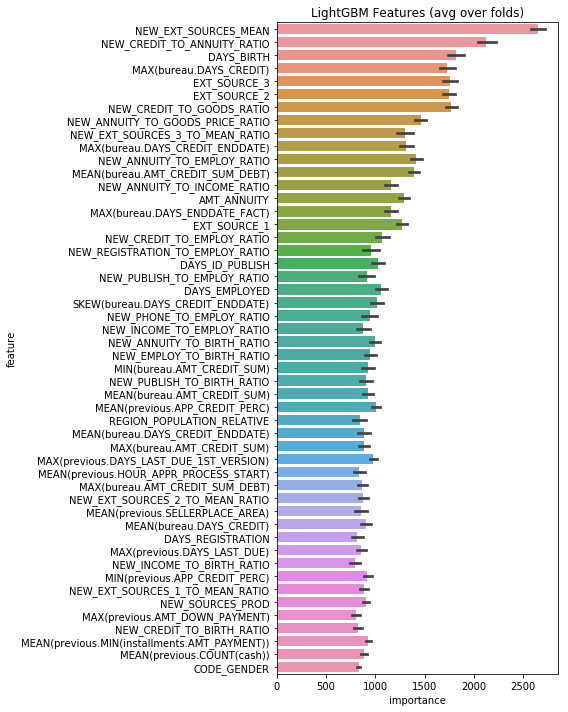

In [9]:
display_importances(feature_importance_df)

In [10]:
time.time() - st

58900.85443544388